In [17]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests

# EDA

Здесь посмотрим на данные, которые лежат в выборке без аномалий и те, которые лежат в выборке с аномалиями. Посмотрим на колонки, которые уже распаршены, а именно 'addr', 'handshake', 'packets', 'port', 'proto'. Далее из колонки packets в ходе EDA буду выделять новые колонки.

Наша задача сейчас - верхнеуровнево понять, насколько то, что есть, будет полезно в ходе машинного обучения.
1. Как много пропусков
2. Нет ли статичных колонок

Лишнее удалим.

In [2]:
files_list = [
'sessions_of_https_sessions_00002_20231027223905.pcapng.json',
'sessions_of_https_sessions_00003_20231027224424.pcapng.json',
'sessions_of_https_sessions_00004_20231027225017.pcapng.json',
'sessions_of_https_sessions_00005_20231027225648.pcapng.json',
'sessions_of_https_sessions_00006_20231027230320.pcapng.json',
'sessions_of_https_sessions_00007_20231027230845.pcapng.json',
'sessions_of_https_sessions_00008_20231027231514.pcapng.json',
'sessions_of_https_sessions_00009_20231027232214.pcapng.json',
'sessions_of_https_sessions_00010_20231027233030.pcapng.json',
'sessions_of_https_sessions_00011_20231027233812.pcapng.json',
'sessions_of_https_sessions_00012_20231027234554.pcapng.json',
'sessions_of_https_sessions_00013_20231027235240.pcapng.json',
'sessions_of_https_sessions_00014_20231027235915.pcapng.json',
'sessions_of_https_sessions_00015_20231028000629.pcapng.json',
'sessions_of_https_sessions_00016_20231028001324.pcapng.json',
'sessions_of_https_sessions_00017_20231028002136.pcapng.json',
'sessions_of_https_sessions_00018_20231028002753.pcapng.json',
'sessions_of_https_sessions_00019_20231028003349.pcapng.json']

In [3]:
with open("C:/Users/60135487/Documents/project/Данные по годовому проекту/sessions_of_https_sessions_00001_20231027222814.pcapng.json", 'r') as file:
    variable_name = json.load(file)
len(variable_name)

1138

In [4]:
for f in files_list:
    with open("C:/Users/60135487/Documents/project/Данные по годовому проекту/" + f, 'r') as file:
        variable_name = variable_name + json.load(file)
len(variable_name) 

17841

In [5]:
columns_list = variable_name[0].keys()
df_train = pd.DataFrame(columns = columns_list)

In [6]:
columns_list

dict_keys(['addr', 'handshake', 'packets', 'port', 'proto'])

In [7]:
for i in range(0, len(variable_name)):
    df_train=pd.concat([df_train, pd.DataFrame([variable_name[i]])], ignore_index=True)

Смотрим на процент уникальных данных в колонках

In [8]:
round(df_train.addr.nunique() / df_train.shape[0] * 100, 2)

35.65

In [9]:
round(df_train.port.nunique() / df_train.shape[0] * 100, 2)

0.01

In [10]:
round(df_train.proto.nunique() / df_train.shape[0] * 100, 2)

0.01

In [11]:
round(len(df_train[df_train['handshake'].fillna(0) !=0]) / len(df_train) * 100, 2)

74.23

In [12]:
df_train.port.nunique()

1

In [13]:
df_train.proto.nunique()
# кажется, колонку proto вообще нужно дропнуть
# но посмотрим, что лежит в файлах с аномалиями

1

Планы:
1. Продолжу смотреть что в handshake

    1.1. Сделаю бинарную колонку с наличием и отсутствием рукопожатия
    
    1.2. Расшаршу ее глубже, посмотрю что с сертификатами

2. data - превратим в булево поле: есть нераскодированные данные или нет в этом соединении

3. 443, 4433, 80, 8080 это стандартные порты. 35600 - это нестандартный порт. Мы должны сохранить эту колонку

4. Идея представить addr как вектор. Четыре разные колонки с цифрами

    4.1. Вычислить по айпи месторасположение
5. Duration между timestamp'ами - считать среднее, медиану между ними
6. Дропнуть дубликаты
7. Сертификаты - самоподписной, их количество 

In [14]:
df_train['num_timestamps'] = pd.Series()
for i in range(0, len(df_train['packets'])):
    df_train['num_timestamps'][i] = str(df_train['packets'][i]).count('timestamp')

C:\Users\60135487\AppData\Local\Temp\ipykernel_13984\3279060058.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_train['num_timestamps'] = pd.Series()


In [15]:
df_train['timestamps'] = pd.Series()
for i in range(0, len(df_train)):
    if df_train['num_timestamps'][i] != 0 and df_train['num_timestamps'][i] != 1:
        timestamps_list = []
        for j in range(0, len(df_train['packets'][i])):
            timestamps_list.append(df_train['packets'][i][j]['timestamp'])
        df_train['timestamps'][i] = str(timestamps_list)

C:\Users\60135487\AppData\Local\Temp\ipykernel_13984\1899346913.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_train['timestamps'] = pd.Series()


In [16]:
df_train['mean_timestamps'] = pd.Series()
df_train['median_timestamps'] = pd.Series()
for i in range(0, len(df_train)):
    if df_train['num_timestamps'][i] != 0 and df_train['num_timestamps'][i] != 1:
        temp = []
        for j in range(0, int(df_train['num_timestamps'][i])-1):
            temp.append(datetime.fromtimestamp(float(df_train['timestamps'][i].split(', ')[j+1].replace("[","").replace("]","")))- datetime.fromtimestamp(float(df_train['timestamps'][i].split(', ')[j].replace("[","").replace("]",""))))
        df_train['mean_timestamps'][i] = np.mean(temp)
        df_train['median_timestamps'][i] = np.median(temp)

C:\Users\60135487\AppData\Local\Temp\ipykernel_13984\2180900598.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_train['mean_timestamps'] = pd.Series()
C:\Users\60135487\AppData\Local\Temp\ipykernel_13984\2180900598.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_train['median_timestamps'] = pd.Series()


In [18]:
df_train.head()

,addr,handshake,packets,port,proto,num_timestamps,timestamps,mean_timestamps,median_timestamps
0,140.82.121.6,[{'Extension: key_share (len=36)': {'Key Share...,"[{'timestamp': 1698434896.269325}, {'timestamp...",443,tcp,25.0,"[1698434896.269325, 1698434896.329026, 1698434...",0:00:00.052712,0:00:00.004318
1,172.64.41.4,[{'Extension: key_share (len=36)': {'Key Share...,"[{'timestamp': 1698434900.01603}, {'timestamp'...",443,tcp,12880.0,"[1698434900.01603, 1698434900.01614, 169843490...",0:00:00.045894,0:00:00.000647
2,34.160.144.191,[{'Extension: application_layer_protocol_negot...,"[{'timestamp': 1698434900.921825}, {'timestamp...",443,tcp,37.0,"[1698434900.921825, 1698434900.922489, 1698434...",0:00:04.746263,0:00:00.001422
3,209.85.233.104,[{'Extension: key_share (len=36)': {'Key Share...,"[{'timestamp': 1698434901.770399}, {'timestamp...",443,tcp,899.0,"[1698434901.770399, 1698434901.771339, 1698434...",0:00:00.550077,0:00:00.000336
4,209.85.233.94,[{'Extension: key_share (len=36)': {'Key Share...,"[{'timestamp': 1698434902.141365}, {'timestamp...",443,tcp,493.0,"[1698434902.141365, 1698434902.142996, 1698434...",0:00:01.213314,0:00:00.002324


### Посмотрим на данные с аномалиями

In [19]:
anomaly_data = [
'sessions_of_2023-02-Unit42-Wireshark-quiz.pcap.json',
'sessions_of_2023-03-Unit42-Wireshark-quiz.pcap.json',
'sessions_of_2023-04-Unit42-Wireshark-quiz.pcap.json',
'sessions_of_2023-07-Unit42-Wireshark-quiz.pcap.json'
]

In [20]:
with open("C:/Users/60135487/Documents/project/Данные по годовому проекту/sessions_of_2023-01-Unit42-Wireshark-quiz.pcap.json", 'r') as file:
    anomaly = json.load(file)
len(anomaly)

11

In [21]:
for f in anomaly_data:
    with open("C:/Users/60135487/Documents/project/Данные по годовому проекту/" + f, 'r') as file:
        anomaly = anomaly + json.load(file)
len(anomaly) 

1265

In [22]:
columns_list_anomaly = anomaly[0].keys()
df_train_anomaly = pd.DataFrame(columns = columns_list_anomaly)
for i in range(0, len(anomaly)):
    df_train_anomaly=pd.concat([df_train_anomaly, pd.DataFrame([anomaly[i]])], ignore_index=True)

In [23]:
df_train_anomaly.addr.nunique()

362

In [24]:
df_train_anomaly.port.nunique()

814

In [25]:
df_train_anomaly.proto.nunique()

3

In [26]:
df_train_anomaly['num_timestamps'] = pd.Series()
for i in range(0, len(df_train_anomaly['packets'])):
    df_train_anomaly['num_timestamps'][i] = str(df_train_anomaly['packets'][i]).count('timestamp')

In [27]:
df_train_anomaly['timestamps'] = pd.Series()
for i in range(0, len(df_train_anomaly)):
    if df_train_anomaly['num_timestamps'][i] != 0 and df_train_anomaly['num_timestamps'][i] != 1:
        timestamps_list = []
        for j in range(0, len(df_train_anomaly['packets'][i])):
            timestamps_list.append(df_train_anomaly['packets'][i][j]['timestamp'])
        df_train_anomaly['timestamps'][i] = str(timestamps_list)

In [28]:
df_train_anomaly['mean_timestamps'] = pd.Series()
df_train_anomaly['median_timestamps'] = pd.Series()
for i in range(0, len(df_train_anomaly)):
    if df_train_anomaly['num_timestamps'][i] != 0 and df_train_anomaly['num_timestamps'][i] != 1:
        temp = []
        for j in range(0, int(df_train_anomaly['num_timestamps'][i])-1):
            temp.append(datetime.fromtimestamp(float(df_train_anomaly['timestamps'][i].split(', ')[j+1].replace("[","").replace("]","")))- datetime.fromtimestamp(float(df_train_anomaly['timestamps'][i].split(', ')[j].replace("[","").replace("]",""))))
        df_train_anomaly['mean_timestamps'][i] = np.mean(temp)
        df_train_anomaly['median_timestamps'][i] = np.median(temp)

In [29]:
df_train['anomaly'] = 0
df_train_anomaly['anomaly'] = 1
# генерирую колонку ответов

In [30]:
df = pd.concat([df_train, df_train_anomaly])
# генерирую общий датафрейм

In [31]:
df['mean_timestamps'] = df['mean_timestamps'].map(lambda x: pd.to_timedelta(x).microseconds)
df['median_timestamps'] = df['median_timestamps'].map(lambda x: pd.to_timedelta(x).microseconds)
# для удобства перевожу в инт

Сравним между собой данные с аномалиями и данные с отсутствием аномалий. Если найдем колонки, не имеющие разницы, они станут кандидатами на удаление. В первую очередь посмотримна сгенерированные нами колонки.

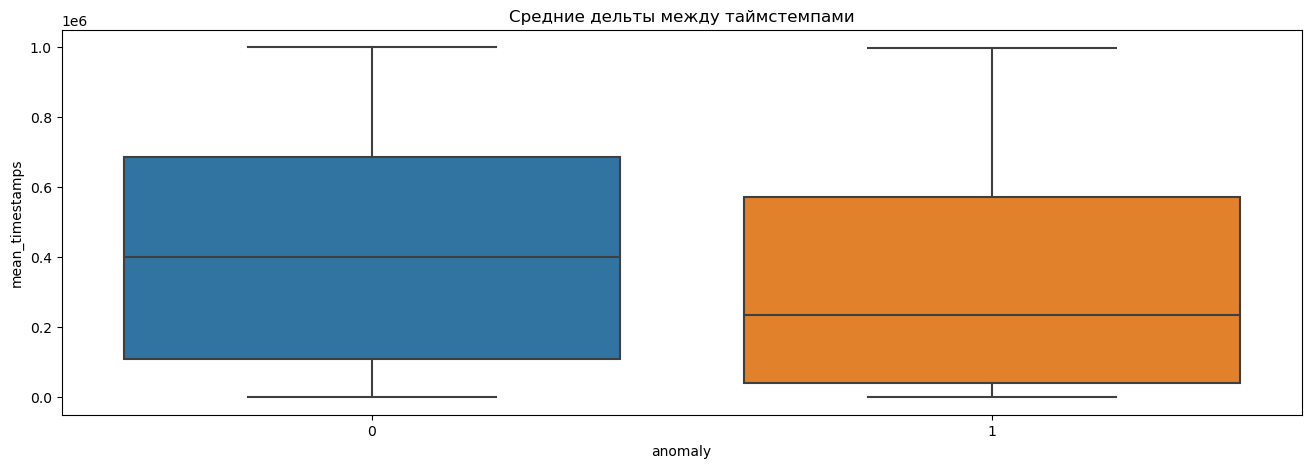

In [104]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'mean_timestamps').set_title("Средние дельты между таймстемпами")

plt.xticks(rotation=0)
plt.show()

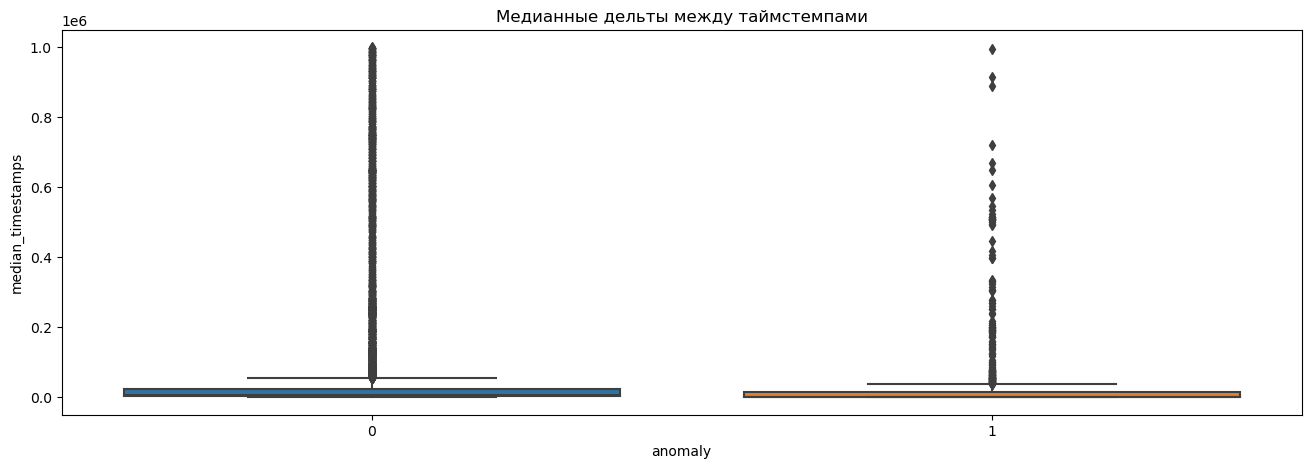

In [37]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'median_timestamps').set_title("Медианные дельты между таймстемпами")

plt.xticks(rotation=0)
plt.show()

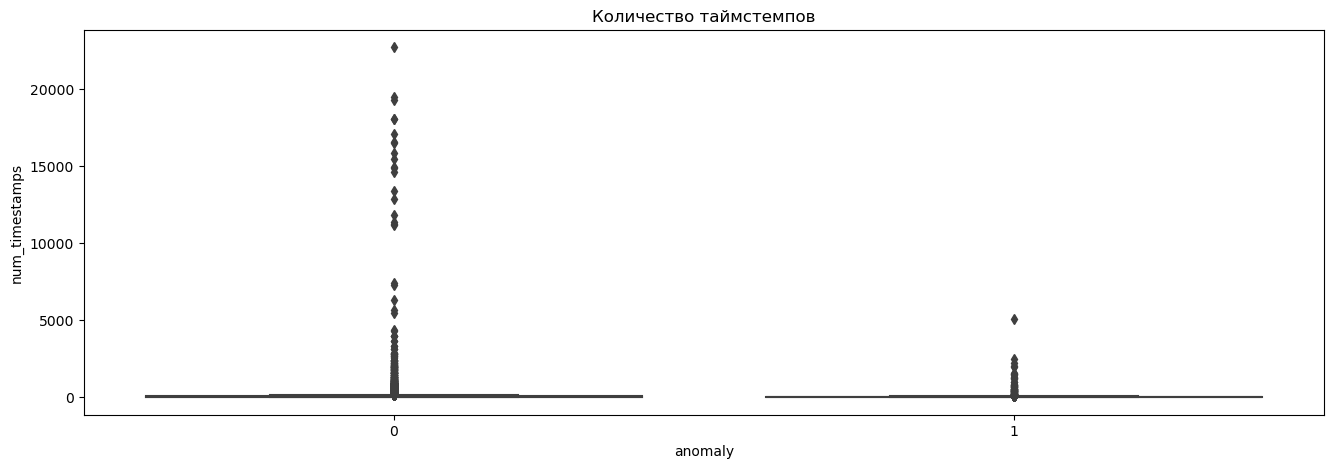

In [38]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'num_timestamps').set_title("Количество таймстемпов")

plt.xticks(rotation=0)
plt.show()

Посмотрим, есть ли различия между портами, их количеством в группировке по классам

In [39]:
df.groupby(['anomaly'], as_index=False).port.nunique()

,anomaly,port
0,0,1
1,1,814


Посмотрим, есть ли различия между proto, их количеством в группировке по классам

In [40]:
df.groupby(['anomaly'], as_index=False).proto.nunique()

,anomaly,proto
0,0,1
1,1,3


Пока кажется, что каждую из фичей 'port', 'proto', 'num_timestamps', 'mean_timestamps', 'median_timestamps' нужно оставить. Попробуем сгененрировать фичи из колонки 'addr': найдем страну.

In [41]:
def get_ip():
    response = requests.get('https://api64.ipify.org?format=json').json()
    return response["ip"]


def get_location(ip):
    # ip_address = get_ip()
    ip_address = ip
    response = requests.get(f'https://ipapi.co/{ip_address}/json/').json()
    location_data = {
        "ip": ip_address,
        "city": response.get("city"),
        "region": response.get("region"),
        "country": response.get("country_name")
    }
    return location_data

get_location(get_ip())['country']

'Russia'

In [43]:
get_location(get_ip())['country']

'Russia'

In [44]:
cntr = []
for i in df['addr']:
    cntr.append(get_location(i)['country'])
df['country'] = cntr

In [45]:
df.country.nunique()

17

In [48]:
df.groupby(['anomaly'], as_index=False).country.nunique()
# очевидны отличия между классами

,anomaly,country
0,0,17
1,1,0


In [52]:
df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly', 'country']].shape

(19106, 8)

In [54]:
df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates().shape

(19086, 8)

Так как генерировали много признаков из одной колонки, посмотрим на корреляции

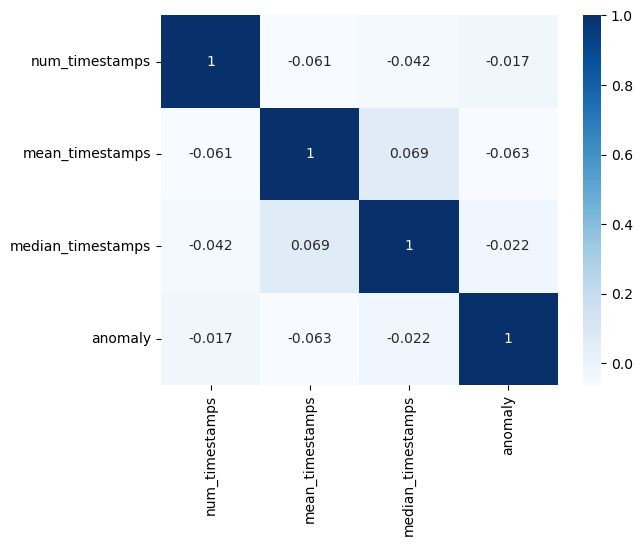

In [57]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly', 'country']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

# Pipeline

## Итерация 1

Обучим на этих фичах модель. Для первого подхода выбрала catboost. 

Затем замерим качество на отложенной выборке, посмотрим, какие фичи наиболее важны.

In [237]:
X = df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

y = X['anomaly']
X = X.drop(['anomaly'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [238]:
!pip install catboost
from catboost import CatBoostClassifier

clf = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr', 'port', 'proto', 'country'])

In [239]:
model_1 = clf.fit(Xtrain, ytrain)

In [240]:
sum(model_1.predict(Xtest) ==1)
# какие-то все же пометил аномалиями
# отлично, посчитаем roc_auc_score

333

In [241]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

round(roc_auc_score(ytest, model_1.predict(Xtest)), 2)
# для сравнения с другими моделями

0.94

In [242]:
round(f1_score(ytest, model_1.predict(Xtest)), 2)
# для оценки работы модели

0.93

In [243]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.9418307485911448


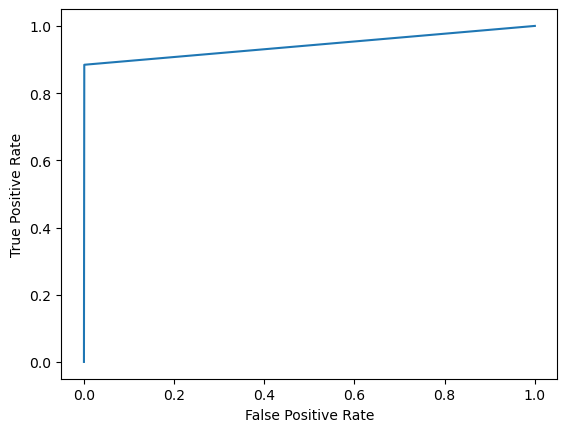

In [244]:
plot_roc_curve(ytest, model_1.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_1.predict(Xtest))}')

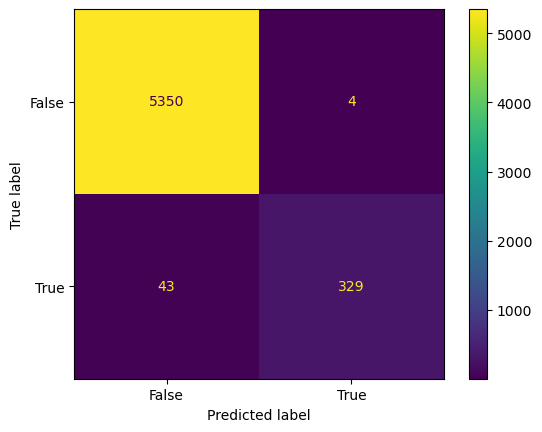

In [245]:
confusion_matrix = confusion_matrix(ytest, model_1.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

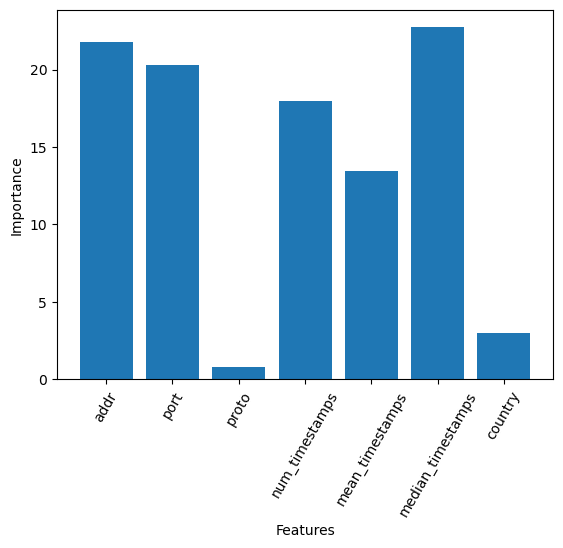

In [246]:
plt.bar(Xtrain.columns, model_1.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show

## Промежуточные итоги

Очень похоже, что модель переобучилась под наши данные, и из-за их количества мы не увидели это на тесте. Попробуем проверить эту гипотезу, начнем с исследования порта. Сколько правильных ответов, когда порт 443 и когда это аномалия?

In [250]:
Xtest['predict'] = model_1.predict(Xtest)
Xtest['ans'] = ytest
len(Xtest[(Xtest['port'] == '443') & (Xtest['ans'] == 1) & (Xtest['predict'] == 1)])

41

А сколько неверно?

In [251]:
len(Xtest[(Xtest['port'] == '443') & (Xtest['ans'] == 1) & (Xtest['predict'] == 0)])

43

То есть примерно поровину модель ошиблась на 443 порте. На неаномалиях этот порт единственный. Попробуем просто выкинуть эту фичу, похоже, что модель под нее переобучилась.

Продолжим с колонкой айпи-адреса. Среди вредных адресов встречается ли один какой-то?

In [252]:
Xtest[(Xtest['ans'] == 1)].value_counts('addr')

addr
10.4.19.138       225
10.4.19.143        20
10.0.0.6            5
10.4.19.19          4
10.7.10.9           4
                 ... 
20.12.23.50         1
20.106.86.13        1
199.59.242.150      1
198.38.82.29        1
99.83.154.118       1
Length: 112, dtype: int64

In [254]:
len(Xtest[(Xtest['ans'] == 1) & (Xtest['addr'] == '10.4.19.138') & (Xtest['predict'] == 1)]) / 225

1.0

В ста процентах случаев с первым адресом модель угадала правильный ответ. Явно присутствует переобученность и на этой колонке:

1. Кажется, строки с первым адресом стоит выкинуть. 

2. И от самих адресов оставим также первые две цифры.

## Итерация 2

Выкинем фичу порт и из адреса сделаем две новые фичи. Посмотрим, как измерится качество модели.

In [255]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

y = X['anomaly']
X = X.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [256]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr_1', 'addr_2', 'proto', 'country'])

In [257]:
model = clf.fit(Xtrain, ytrain)

In [258]:
sum(model.predict(Xtest) ==1)
# какие-то все же пометил аномалиями
# отлично, посчитаем roc_auc_score

77

In [259]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

round(roc_auc_score(ytest, model.predict(Xtest)), 2)
# для сравнения с другими моделями

0.67

In [260]:
round(f1_score(ytest, model.predict(Xtest)), 2)
# для оценки работы модели

0.48

model AUC score: 0.6717933892056123


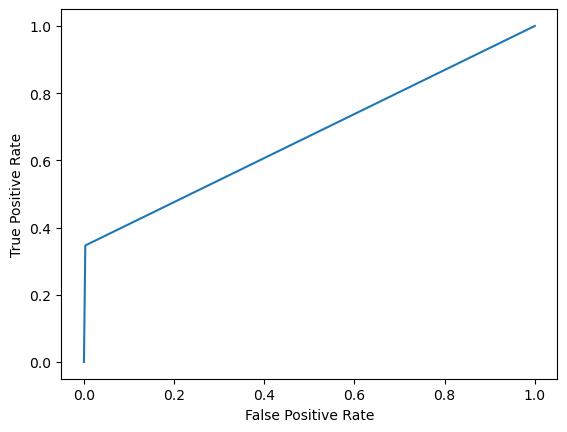

In [261]:
plot_roc_curve(ytest, model.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model.predict(Xtest))}')

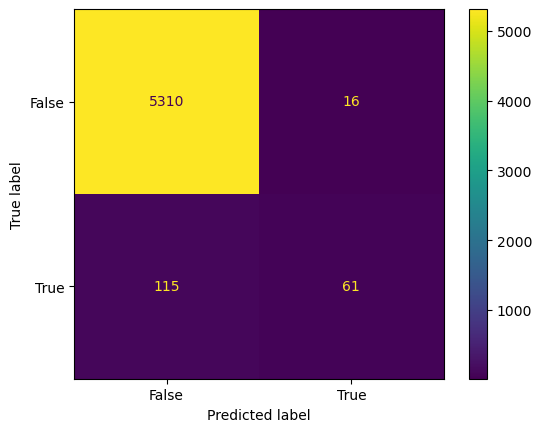

In [262]:
confusion_matrix = confusion_matrix(ytest, model.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

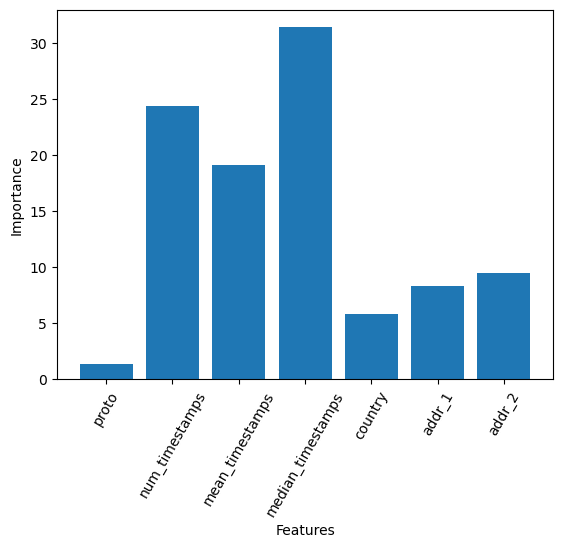

In [263]:
plt.bar(Xtrain.columns, model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show

# Итого,

по результатам EDA выделила 7 фичей, из них 4 - качественные: addr, port, proto, country. 3 количественные фичи (num_timestamps, mean_timestamps, median_timestamps) сгенерированы из таймстемпов. Корреляция между этими фичами почти отсутствует, поэтому все из них взяла в модель.

Обучила катбуст, оценка на тесте - 0.94. Выявили переобученность модели под две фичи и провели еще одну итерацию обучения модели. на новых фичах: убрали порт, часть записей с одним и тем же адресом и от самого адреса оставили первые две цифры. Качество модели драматически упало до 0.67.

Цель последующей работы - дотянуть roc_auc_score до 0.9. Что будем делать:

1. Генерировать и тестировать новые фичи

    1.1. Возможно, сравним результат также с другой моделью
    

2. Обучим нейронную сеть

Recall в данной задаче нам важнее. Важно не пустить пользователя на вредоносный сайт, но при этом нужно понимать, что иногда мы можем не пустить его и на нормальный сайт. В данном случае высока цена ошибки будет высока. Финальный датафрейм выглядит так:

In [264]:
Xtrain.head()

,proto,num_timestamps,mean_timestamps,median_timestamps,country,addr_1,addr_2
16908,tcp,26.0,240752.0,22548.0,0,13,69
17698,tcp,253.0,477238.0,1460.0,0,52,85
8725,tcp,23.0,466983.0,6277.0,0,184,51
11522,tcp,30.0,711712.0,19397.0,0,44,206
520,tcp,56.0,115528.0,3173.0,0,108,156
